# First Neural Network tests on The REWE Dataset
## (not used anymore)

## Dataset

As a starting point the dataset https://universe.roboflow.com/getze-mznzo/ratzz seems like a perfect option as it has german products in a shopping cart from REWE.

<span style="color:red">

Note:
    <br>- The dataset is relatively small
    <br>- The training data already has multiple objects per picture
    <br>- No prices yet
   
</span>
<span style="color:yellow">

Augmentations:
    <br>- Rotation: Between -11° and +11°
   
</span>



### Download dataset

In [2]:
from roboflow import Roboflow

rf = Roboflow(api_key="3HPFidU9BPB8vr2PR1PU")
project = rf.workspace("getze-mznzo").project("ratzz")
version = project.version(4)
dataset = version.download("yolov7", location="datasets/rewe-roboflow")

ModuleNotFoundError: No module named 'roboflow'

### Visualize the labels 

In [3]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

def visualize_yolo_labels(image_path, label_path, class_names):
    """
    Visualizes YOLO labels on an image.

    Args:
        image_path (str): Path to the image file.
        label_path (str): Path to the corresponding YOLO label (.txt) file.
        class_names (list): List of class names corresponding to class IDs.
    """
    # Open the image
    img = Image.open(image_path)
    draw = ImageDraw.Draw(img)
    img_width, img_height = img.size
    
    # Read the label file
    with open(label_path, "r") as file:
        labels = file.readlines()
    
    # Loop through each label
    for label in labels:
        # Parse the YOLO label
        label = label.strip().split()
        class_id = int(label[0])
        x_center, y_center, width, height = map(float, label[1:])
        
        # Convert normalized coordinates to absolute pixel values
        x_center *= img_width
        y_center *= img_height
        width *= img_width
        height *= img_height
        
        # Calculate the top-left and bottom-right corners of the bounding box
        x_min = int(x_center - width / 2)
        y_min = int(y_center - height / 2)
        x_max = int(x_center + width / 2)
        y_max = int(y_center + height / 2)
        
        # Draw the bounding box and label
        draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=3)
        draw.text((x_min, y_min - 10), class_names[class_id], fill="black", )
    
    # Display the image
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

Load the different class names from data.yaml

In [4]:
import yaml

# Load the data.yaml file
with open("datasets/rewe-roboflow/data.yaml", "r") as file:
    data_yaml = yaml.safe_load(file)

# Extract class names
class_names = data_yaml['names']

print(class_names)

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/rewe-roboflow/data.yaml'

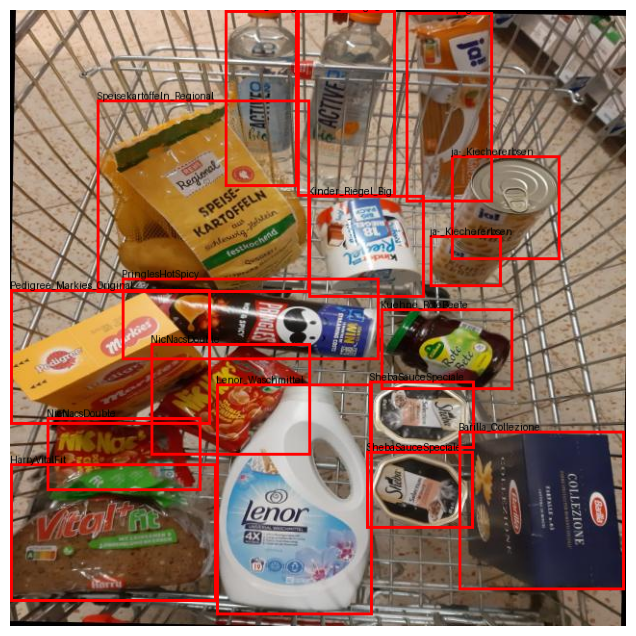

In [6]:
image_path = "datasets/rewe-roboflow/train/images/54_jpg.rf.9c8372a8728d533276029a6ad3a98c80.jpg"
label_path = "datasets/rewe-roboflow/train/labels/54_jpg.rf.9c8372a8728d533276029a6ad3a98c80.txt"

visualize_yolo_labels(image_path, label_path, class_names)

## YOLO (You only look once)

### Test inference

In [13]:
from ultralytics import YOLO

model = YOLO('yolo/yolov8n.pt')
model.predict(
    source=image_path, #"car.jpg"
    conf=0.1,
    save=True,
    project='yolo/runs',
)

# Count total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")


image 1/1 /Users/mats/Local/TinyML-MT/datasets/rewe-roboflow/train/images/54_jpg.rf.9c8372a8728d533276029a6ad3a98c80.jpg: 640x640 3 bottles, 2 bowls, 2 clocks, 35.6ms
Speed: 2.0ms preprocess, 35.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to yolo/runs/predict
Total parameters: 3151904
Trainable parameters: 0


The standard inference of Yolo(v8) is clueless as there are only basic categories. 

### Training using custom dataset

In [20]:
model.train(
    data='datasets/rewe-roboflow/data.yaml',
    epochs=30,
    batch=20,
    imgsz=640,
    project='yolo/yolo_rewe',
    name='experiment1',
    verbose=True,
    device='mps'
)

Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.5.1 MPS (Apple M4 Pro)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=datasets/rewe-roboflow/data.yaml, epochs=30, time=None, patience=100, batch=20, imgsz=640, save=True, save_period=-1, cache=False, device=mps, workers=0, project=yolo_rewe, name=experiment1, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxe

train: Scanning /Users/mats/Local/TinyML-MT/datasets/rewe-roboflow/train/labels.cache... 334 images, 12 backgrounds, 0 corrupt: 100%|██████████| 334/334 [00:00<?, ?it/s]
val: Scanning /Users/mats/Local/TinyML-MT/datasets/rewe-roboflow/valid/labels.cache... 33 images, 1 backgrounds, 0 corrupt: 100%|██████████| 33/33 [00:00<?, ?it/s]

Plotting labels to yolo_rewe/experiment1/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000278, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00046875), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to yolo_rewe/experiment1
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      6.07G      1.565      3.373      1.575        157        640: 100%|██████████| 17/17 [00:33<00:00,  1.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:11<00:00, 11.32s/it]

                   all         33        148      0.491      0.183      0.218      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30       5.9G      1.523      3.153      1.565        107        640: 100%|██████████| 17/17 [00:32<00:00,  1.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.13s/it]

                   all         33        148      0.795      0.159      0.232      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      5.92G      1.448      3.062      1.508         97        640: 100%|██████████| 17/17 [00:31<00:00,  1.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.95s/it]

                   all         33        148      0.687      0.186      0.217      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      5.94G       1.41      2.887      1.472        139        640: 100%|██████████| 17/17 [00:31<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.66s/it]

                   all         33        148      0.761      0.177      0.221      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      5.98G      1.366      2.706      1.458         81        640: 100%|██████████| 17/17 [00:32<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.00s/it]

                   all         33        148      0.745      0.189      0.225      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      5.98G      1.302      2.563      1.419        108        640: 100%|██████████| 17/17 [00:31<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.64s/it]

                   all         33        148        0.5      0.208      0.219      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30         6G      1.266      2.425      1.385         79        640: 100%|██████████| 17/17 [00:31<00:00,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.89s/it]

                   all         33        148      0.602      0.219      0.261        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      6.04G      1.246      2.277      1.391         85        640: 100%|██████████| 17/17 [00:33<00:00,  1.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.46s/it]

                   all         33        148      0.631      0.267      0.296      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      6.02G      1.215      2.113      1.367        134        640: 100%|██████████| 17/17 [00:33<00:00,  1.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.83s/it]

                   all         33        148      0.627      0.243      0.259      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      6.04G      1.164      1.998      1.338        116        640: 100%|██████████| 17/17 [00:30<00:00,  1.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.79s/it]

                   all         33        148      0.566       0.24      0.255      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      6.11G      1.157      1.906      1.327        101        640: 100%|██████████| 17/17 [00:26<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.92s/it]

                   all         33        148      0.539      0.243      0.278      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      6.11G      1.165      1.879      1.314        116        640: 100%|██████████| 17/17 [00:27<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.96s/it]

                   all         33        148      0.482      0.239      0.249        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30       6.1G      1.136      1.797      1.326        110        640: 100%|██████████| 17/17 [00:25<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.34s/it]

                   all         33        148       0.84      0.256      0.284      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      6.19G      1.121      1.718      1.297        131        640: 100%|██████████| 17/17 [00:32<00:00,  1.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.54s/it]

                   all         33        148      0.812       0.27      0.284      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      6.17G      1.106      1.654       1.29        113        640: 100%|██████████| 17/17 [00:29<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.57s/it]

                   all         33        148       0.68      0.256      0.269      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      6.15G       1.09      1.593      1.273        132        640: 100%|██████████| 17/17 [00:31<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.27s/it]

                   all         33        148      0.662      0.277      0.282       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      6.19G      1.062      1.548      1.268         89        640: 100%|██████████| 17/17 [00:27<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.65s/it]

                   all         33        148      0.694      0.277      0.287      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      6.23G      1.071      1.532      1.262        120        640: 100%|██████████| 17/17 [00:36<00:00,  2.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.94s/it]

                   all         33        148      0.714      0.251      0.264      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      6.23G      1.068      1.501      1.259         98        640: 100%|██████████| 17/17 [00:39<00:00,  2.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.58s/it]

                   all         33        148      0.724      0.248      0.264      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      6.26G      1.034       1.45      1.247        122        640: 100%|██████████| 17/17 [00:37<00:00,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.41s/it]

                   all         33        148      0.718      0.239      0.264      0.208


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      6.31G     0.9197      1.371      1.197         74        640: 100%|██████████| 17/17 [00:37<00:00,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.02s/it]


                   all         33        148      0.849      0.223      0.253      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      6.32G     0.9064      1.285      1.193         51        640: 100%|██████████| 17/17 [00:32<00:00,  1.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.12s/it]

                   all         33        148      0.864      0.225      0.257      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      6.32G     0.8493      1.226      1.167         55        640: 100%|██████████| 17/17 [00:32<00:00,  1.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.62s/it]

                   all         33        148      0.835      0.237       0.26      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      6.34G     0.8522      1.179      1.172         58        640: 100%|██████████| 17/17 [00:29<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.10s/it]

                   all         33        148      0.865      0.241      0.259      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      6.38G     0.8598      1.207      1.168         71        640: 100%|██████████| 17/17 [00:30<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  6.00s/it]

                   all         33        148       0.87      0.262      0.288      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      6.36G     0.8444      1.144      1.153         61        640: 100%|██████████| 17/17 [00:33<00:00,  1.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.60s/it]

                   all         33        148      0.801      0.245      0.259      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      6.28G     0.8445      1.176      1.162         38        640: 100%|██████████| 17/17 [00:34<00:00,  2.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.52s/it]

                   all         33        148      0.815        0.2      0.216      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      6.42G     0.8442      1.142      1.151         74        640: 100%|██████████| 17/17 [00:35<00:00,  2.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.74s/it]

                   all         33        148       0.87      0.218      0.239       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      6.46G     0.8335      1.145      1.133         52        640: 100%|██████████| 17/17 [00:34<00:00,  2.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.67s/it]

                   all         33        148      0.882      0.197      0.217      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      6.48G      0.828      1.153      1.149         50        640: 100%|██████████| 17/17 [00:35<00:00,  2.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.32s/it]

                   all         33        148      0.893      0.266      0.285      0.233



30 epochs completed in 0.338 hours.
Optimizer stripped from yolo_rewe/experiment1/weights/last.pt, 6.3MB
Optimizer stripped from yolo_rewe/experiment1/weights/best.pt, 6.3MB

Validating yolo_rewe/experiment1/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.5.1 MPS (Apple M4 Pro)
Model summary (fused): 168 layers, 3,011,888 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.71s/it]


                   all         33        148      0.624      0.197      0.216      0.167
   ActiveO2_Orange_Bio          3          5      0.539        0.4      0.404      0.363
     AlpensalzJodFluor          2          4          1          0          0          0
    Barilla_Collezione          3          5          0          0     0.0154     0.0154
                Burste          4          4      0.623       0.75      0.687      0.469
ChristiansGrod-Rotegruetze-sauerkirsch          2          4          0          0          0          0
     CupNoodlesSobaWok          2          6          0          0          0          0
         Eissbergsalat          1          1          0          0          0          0
         HarryVitalFit          3          4      0.293       0.25      0.252      0.202
     Heinz_Curry_mango          5         10          0          0          0          0
          Heinz_tomato          5         10          0          0          0          0
     

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 27, 28, 30, 31])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x14fe3efd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.0410